# DEMO: Vectorized & Cached Scoring

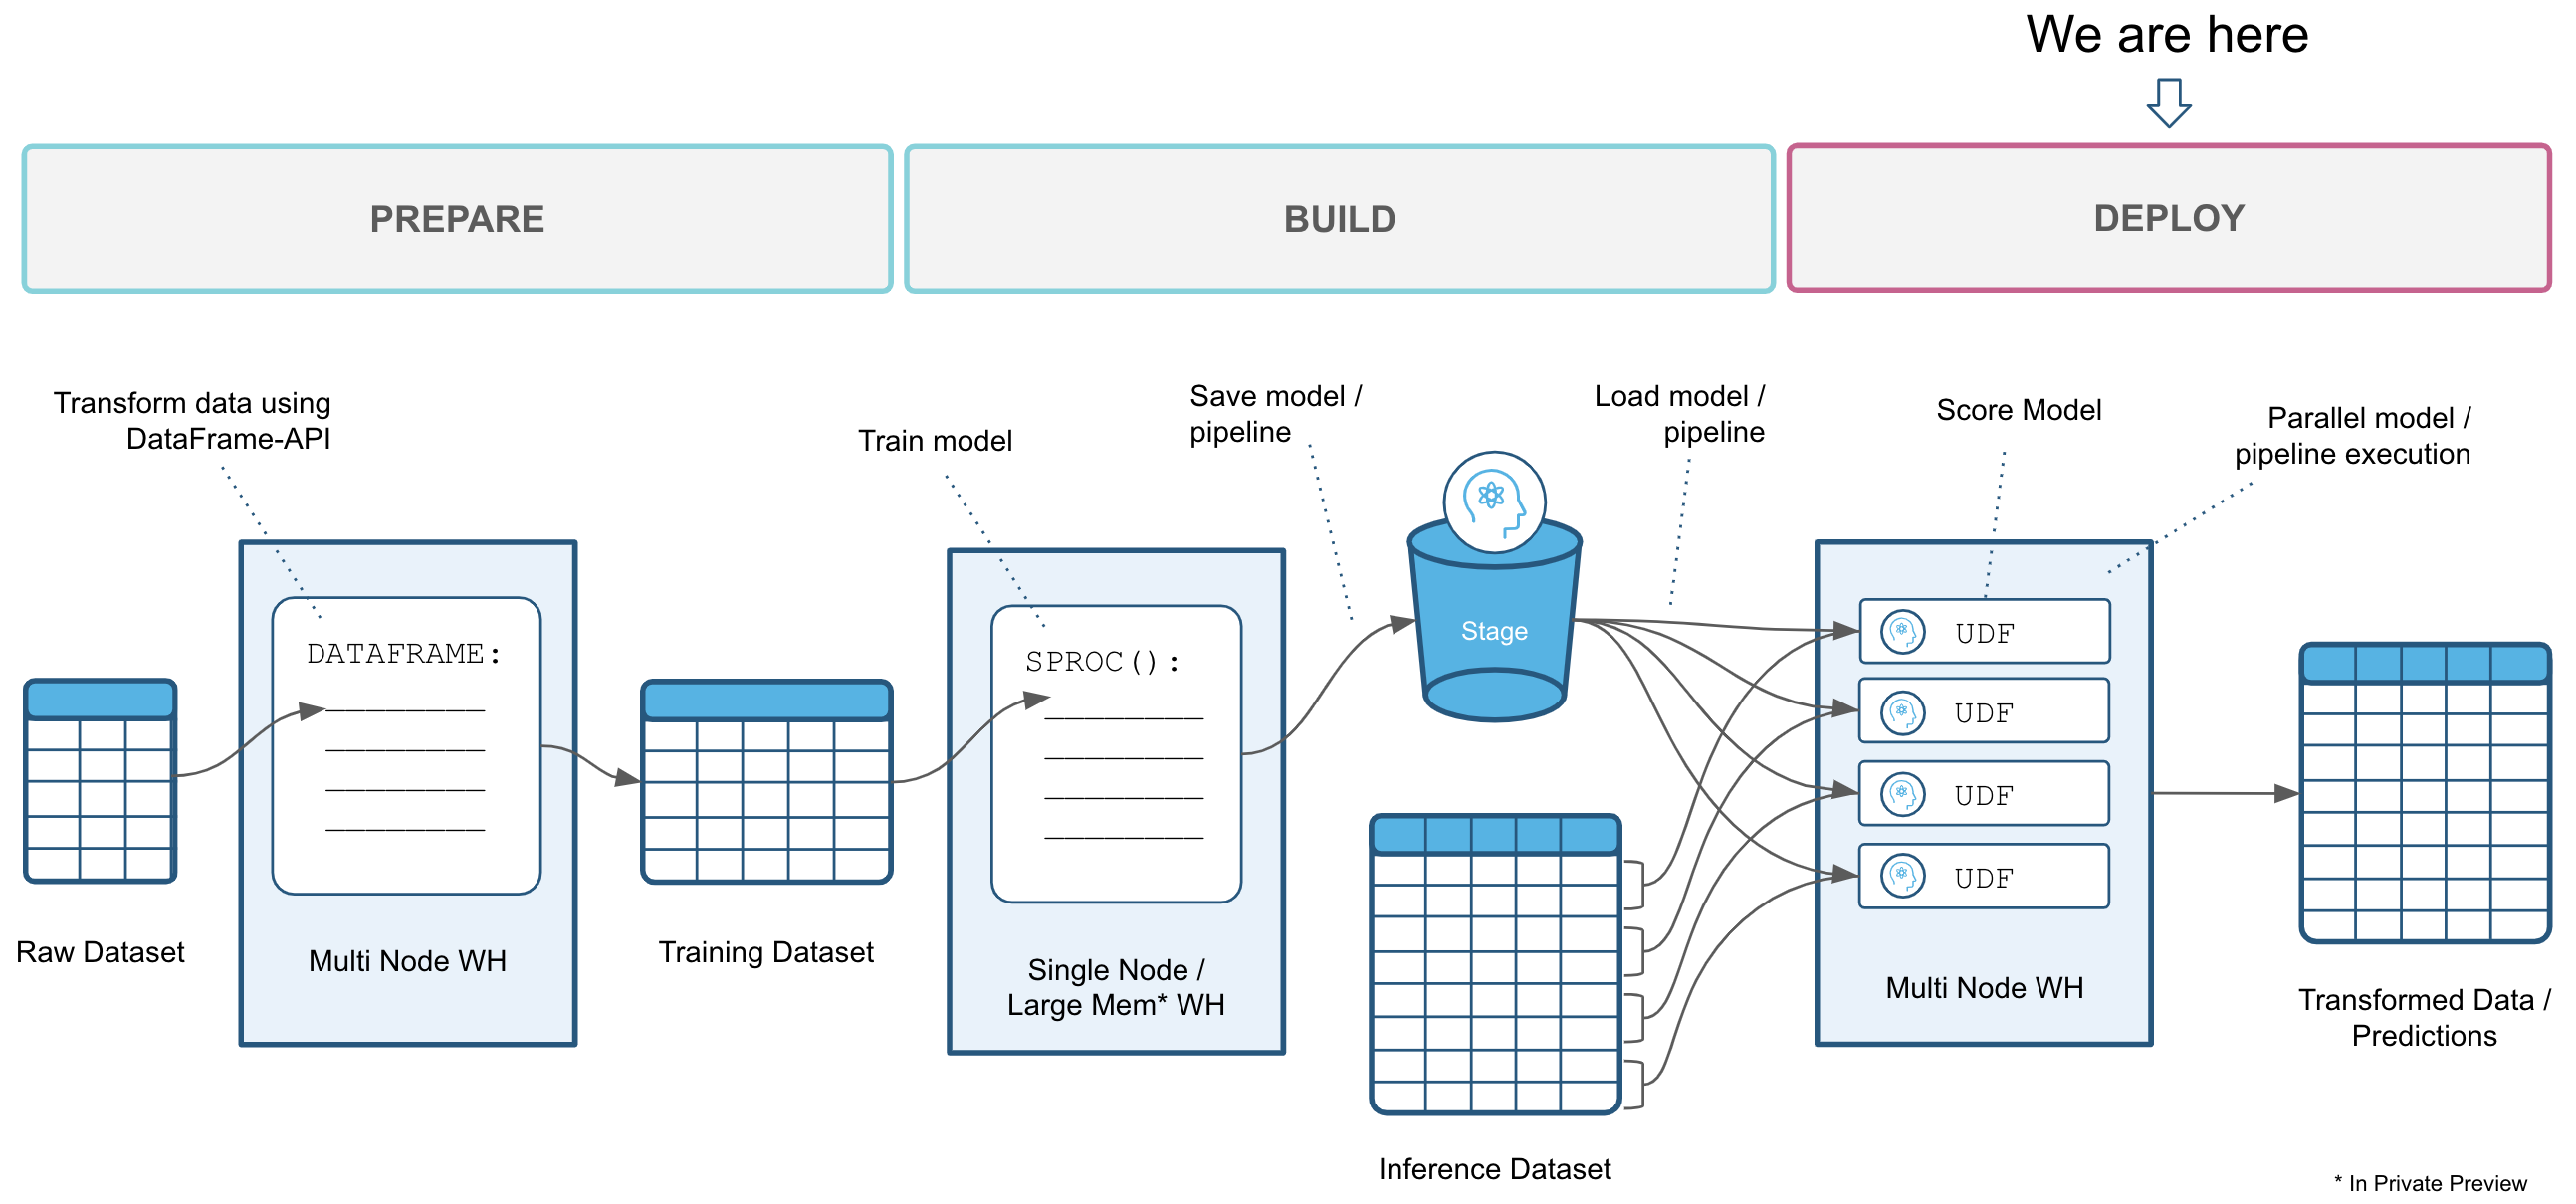

## Imports

In [1]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
import preprocessing

import getpass
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Create Snowpark Session

In [2]:
accountname = getpass.getpass() # ORGNAME-ACCOUNTNAME (separated by minus sign)

········


In [3]:
username = getpass.getpass()    # SNOWFLAKE-USERNAME

········


In [4]:
password = getpass.getpass()    # SNOWFLAKE-PASSWORD

········


In [5]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "HOL_DB",
    "schema": "PUBLIC",
    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

# Model Scoring (Vectorized)

In [6]:
# Lets disable result-cache for a moment to see true scoring-performance
session.sql('ALTER SESSION SET USE_CACHED_RESULT = FALSE').collect() # disable caching so we are not cheating

[Row(status='Statement executed successfully.')]

In [7]:
test_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TEST')
feature_cols = test_sdf.columns
feature_cols.remove('TARGET')
target_col = 'TARGET'

In [8]:
# Define a simple scoring function which is vectorized
def udf_score_logistic_reg_model_vectorized(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    from joblib import load
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'logistic_reg_model.sav'
    model = load(import_dir+model_name)
    scored_data = pd.Series(model.predict(df))
    return scored_data

In [9]:
# Register Vectorized UDF
udf_score_logistic_reg_model_vectorized = session.udf.register(func=udf_score_logistic_reg_model_vectorized, 
                                                               name="udf_score_logistic_reg_model_vectorized", 
                                                               stage_location='@ML_MODELS',
                                                               input_types=[T.FloatType()]*len(feature_cols),
                                                               return_type = T.FloatType(),
                                                               replace=True, 
                                                               is_permanent=True, 
                                                               imports=['@ML_MODELS/logistic_reg_model.sav'],
                                                               packages=['scikit-learn==1.1.1','pandas','joblib'], 
                                                               max_batch_size=1000,
                                                               session=session)

In [10]:
%%time
# Scoring test data with vectorized UDF
scored_sdf = test_sdf.with_column('PREDICTION', udf_score_logistic_reg_model_vectorized(*feature_cols))
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

CPU times: user 7.96 ms, sys: 2.33 ms, total: 10.3 ms
Wall time: 3.23 s


# Model Scoring (Cached)

In [11]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_logistic_reg_model_cached(*args) -> float:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'logistic_reg_model.sav'
    model = load_model(import_dir+model_name)
    scored_data = model.predict(pd.DataFrame([args]))[0]
    return scored_data

In [12]:
# Register UDF
udf_score_logistic_reg_model_cached = session.udf.register(func=udf_score_logistic_reg_model_cached, 
                                                           name="udf_score_logistic_reg_model_cached", 
                                                           stage_location='@ML_MODELS',
                                                           input_types=[T.FloatType()]*len(feature_cols),
                                                           return_type = T.FloatType(),
                                                           replace=True, 
                                                           is_permanent=True, 
                                                           imports=['@ML_MODELS/logistic_reg_model.sav'],
                                                           packages=['scikit-learn==1.1.1','pandas','joblib', 'cachetools'], 
                                                           session=session)

In [13]:
%%time
# Scoring test data with scalar UDF but caching the model
scored_sdf = test_sdf.with_column('PREDICTION', udf_score_logistic_reg_model_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

CPU times: user 9.03 ms, sys: 2.32 ms, total: 11.4 ms
Wall time: 11.3 s


# Model Scoring (Vectorized & Cached)

In [14]:
# Define a simple scoring function
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_score_logistic_reg_model_vec_cached(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    # file-dependencies of UDFs are available in snowflake_import_directory
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'logistic_reg_model.sav'
    model = load_model(import_dir+model_name)
    scored_data = pd.Series(model.predict(df))
    return scored_data

In [15]:
# Register Vectorized UDF
udf_score_logistic_reg_model_vec_cached = session.udf.register(func=udf_score_logistic_reg_model_vec_cached, 
                                                               name="udf_score_logistic_reg_model_vec_cached", 
                                                               stage_location='@ML_MODELS',
                                                               input_types=[T.FloatType()]*len(feature_cols),
                                                               return_type = T.FloatType(),
                                                               replace=True, 
                                                               is_permanent=True, 
                                                               imports=['@ML_MODELS/logistic_reg_model.sav'],
                                                               packages=['scikit-learn==1.1.1','pandas','joblib','cachetools'], 
                                                               max_batch_size=1000,
                                                               session=session)

In [16]:
%%time
# Scoring test data with scalar UDF but caching the model
scored_sdf = test_sdf.with_column('PREDICTION', udf_score_logistic_reg_model_vec_cached(*feature_cols))
scored_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED', mode='overwrite')

CPU times: user 5.58 ms, sys: 4.44 ms, total: 10 ms
Wall time: 3.14 s


In [17]:
# Lets re-enable result-cache
session.sql('ALTER SESSION SET USE_CACHED_RESULT = TRUE').collect()

[Row(status='Statement executed successfully.')]

# Model Evaluation

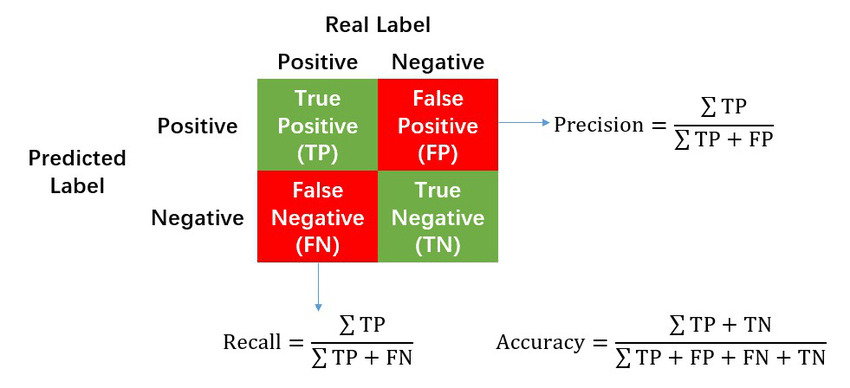

In [18]:
scored_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED_TRAIN_SCORED')

In [19]:
# Obtaining a simple confusion matrix
scored_sdf.group_by(['TARGET','PREDICTION']).count().to_pandas()

,TARGET,PREDICTION,COUNT
0,0,0.0,5994
1,1,0.0,1537
2,1,1.0,4477
3,0,1.0,20


In [20]:
# Define functions to calculate metrics
def accuracy_score(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    accuracy = (tp+tn) / (tp+tn+fn+fp)
    return accuracy

def precision_score(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    precision = tp / (tp+fp)
    return precision

def recall_score(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    recall = tp / (tp+fn)
    return recall

def f1_score(df, y_true, y_pred):
    precision = precision_score(df, y_true=y_true, y_pred=y_pred)
    recall = recall_score(df, y_true=y_true, y_pred=y_pred)
    f1_score = (2*precision*recall) / (precision+recall)
    return f1_score

def confusion_matrix(df, y_true, y_pred):
    conf_matrix = df.group_by([y_true,y_pred]).count().to_pandas()
    tn = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 0)]['COUNT'])
    fp = int(conf_matrix.loc[(conf_matrix[y_true] == 0) & (conf_matrix[y_pred] == 1)]['COUNT'])
    fn = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 0)]['COUNT'])
    tp = int(conf_matrix.loc[(conf_matrix[y_true] == 1) & (conf_matrix[y_pred] == 1)]['COUNT'])
    conf_matrix = [[tn, fp], [fn, tp]]
    return conf_matrix

Accury: 0.8705520452278018
Precision: 0.9955525906159662
Recall: 0.7444296641170602
F1: 0.8518694700789649


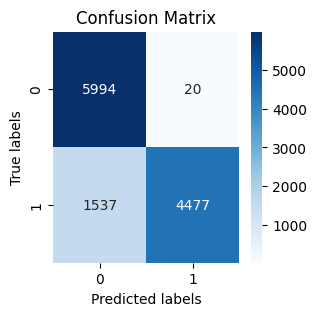

In [22]:
# Visualizing Confusion Matrix
cf_matrix = confusion_matrix(scored_sdf, y_true='TARGET', y_pred='PREDICTION')
fig, ax = plt.subplots(figsize=(3,3))
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Calculating Statistics
print('Accury:', accuracy_score(scored_sdf, y_true='TARGET', y_pred='PREDICTION'))
print('Precision:', precision_score(scored_sdf, y_true='TARGET', y_pred='PREDICTION'))
print('Recall:', recall_score(scored_sdf, y_true='TARGET', y_pred='PREDICTION'))
print('F1:', f1_score(scored_sdf, y_true='TARGET', y_pred='PREDICTION'))